# Neural Net Example

This example uses the data from Fig 6 (fetal human brain).

Data for this figure can be found at the links below:

RNA: https://figshare.com/articles/dataset/Developing_Human_Cortex_RNA_Data/22575376

ATAC: https://figshare.com/articles/dataset/Developing_Human_Cortex_ATAC_Data/22575370

If you do not download them manually, the notebook will do so automatically.

### Important Note:
This notebook is designed to run on the current commit of Multivelo on GitHub. It utilizes features that are not yet available on the current pip release. As such, it is recommended to download Multivelo from GitHub and use that instead of the version available on PyPI.

In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import sys
import multivelo as mv
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import requests

In [2]:
import time

mv.settings.LOG_FILENAME = "nn_example_" + str(time.time()) + ".txt"

In [3]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

In [4]:
rna_url = "https://figshare.com/ndownloader/files/40064350"
atac_url = "https://figshare.com/ndownloader/files/40064347"
  
rna_path = "human_brain_rna_after_filt_r2.h5ad"
atac_path = "human_brain_atac_gene_after_filt_r2.h5ad" 

In [5]:
adata_rna = sc.read(rna_path, backup_url=rna_url)
adata_atac = sc.read(atac_path, backup_url=atac_url)

## Running multi-omic dynamical model

MultiVelo incorporates chromatin accessibility information into RNA velocity and achieves better lineage predictions.

The detailed argument list can be shown with "help(mv.recover_dynamics_chrom)".

### WARNING:

The recover_dynamics_chrom() step can take a long time, even with parallelization. As such, we added a h5ad file to figshare containing the AnnData object returned by recover_dynamics_chrom(). In absence of a local h5ad file of the same name, a cell below the recover_dynamics_chrom() step will download it automatically using sc.read(). If you want to run this notebook in shorter amount of time, then you can run that cell first and skip the preprocessing done in the cells above it. However, if you want to run all cells, including the preprocessing steps, the notebook will write and save the h5ad file itself rather than downloading it from figshare.

In [6]:
scv.tl.recover_dynamics(adata_rna)
scv.tl.velocity(adata_rna, mode="dynamical")
scv.tl.velocity_graph(adata_rna, n_jobs=1)

recovering dynamics (using 1/10 cores)


  0%|          | 0/509 [00:00<?, ?gene/s]

    finished (0:04:22) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/4693 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Neural Net Instructions

In order to run recover_dynamics_chrom() with neural network time prediction, set the neural_net parameter to True. Then specify which device to run it on. The default device is "cpu," but this mode can also run on CUDA GPUs.

In [7]:
# This will take a while. Parallelization is high recommended.

mv.settings.VERBOSITY = 0

adata_result = mv.recover_dynamics_chrom(adata_rna, 
                                        adata_atac,
                                        max_iter=5, 
                                        init_mode="invert",
                                        parallel=True,
                                        n_jobs = 10,
                                        save_plot=False,
                                        rna_only=False,
                                        fit=True,
                                        n_anchors=500,
                                        neural_net=True,
                                        # device="cuda:0",
                                        extra_color_key='cluster'
                                        )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  0%|          | 0/954 [00:00<?, ?it/s]

In [8]:
# Save the result for use later on
adata_result.write("multivelo_result_fig6_nn.h5ad")

## Computing velocity stream and latent time

In [9]:
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

computing velocity graph (using 1/10 cores)


  0%|          | 0/4693 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


## Velocity Streamplot and Latent Time Graph

computing velocity embedding
    finished (0:00:00) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)


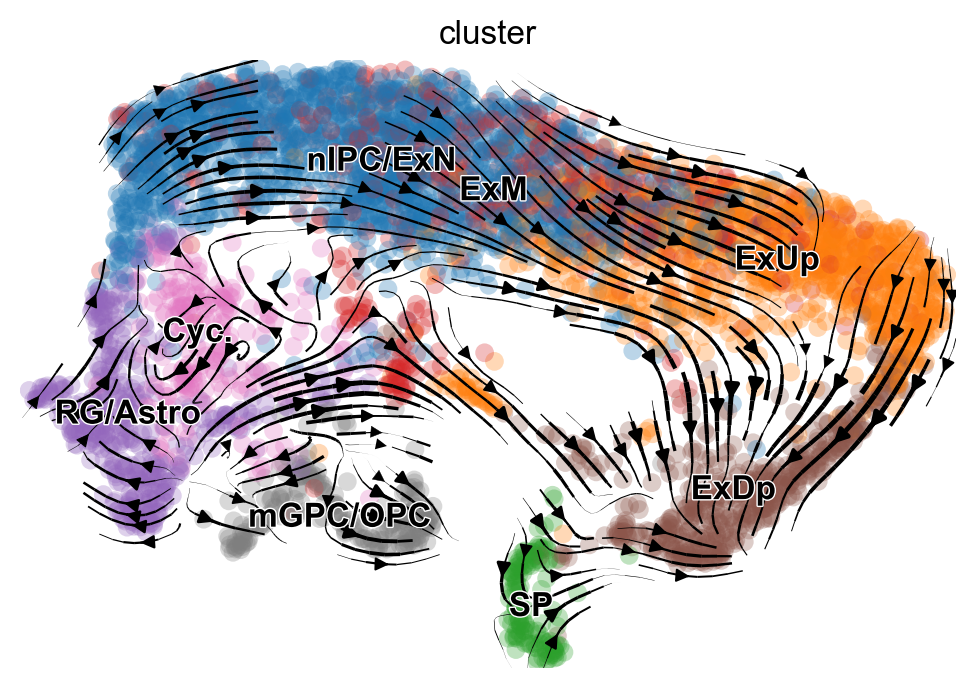

In [10]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='cluster', show=True)

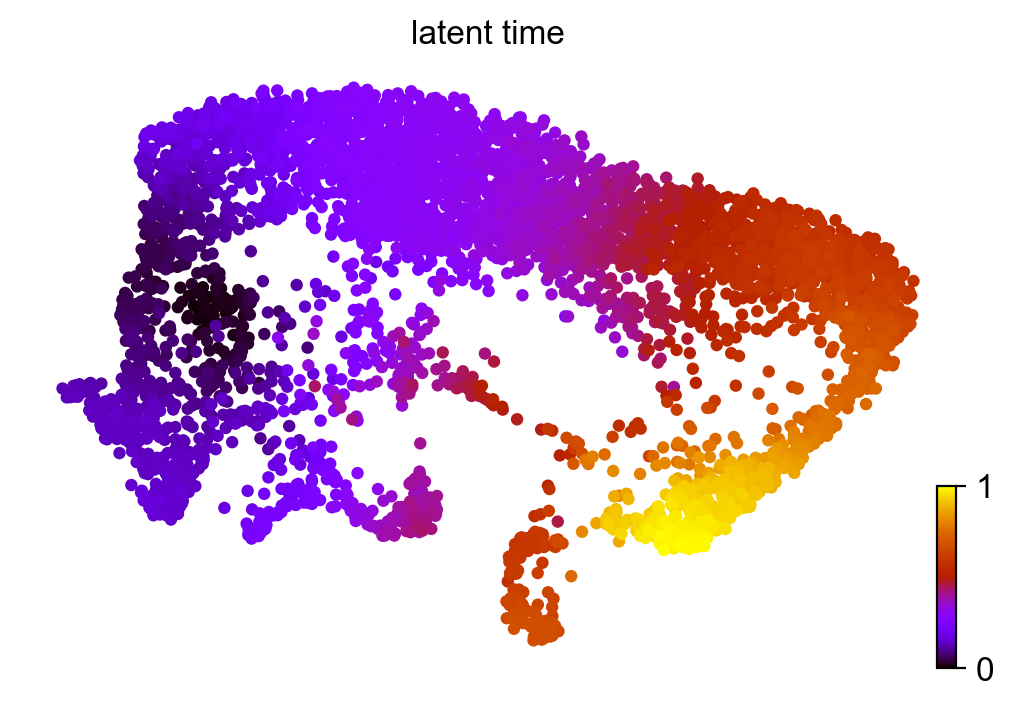

In [11]:
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=80)